In [1]:
print('chat am i cooked ?')

chat am i cooked ?


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from scipy.optimize import minimize

In [3]:
# Seed generator from alphabetic string
def seed_gen(string):
    num_str = [ord(letter) - 96 for letter in string]
    # seed must be between 0 and 2**32 - 1
    return(np.mod(int(''.join(map(str,num_str))),2**32 - 1))

seeds = ['matterlab', 'alba', 'jakob', 'alan']

s = 0 # default seed, used in the main article results
np.random.seed(seed_gen(seeds[s])) 

In [4]:
num_qubits = 4
dev = qml.device("default.qubit", wires=num_qubits)

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Ground state energy')

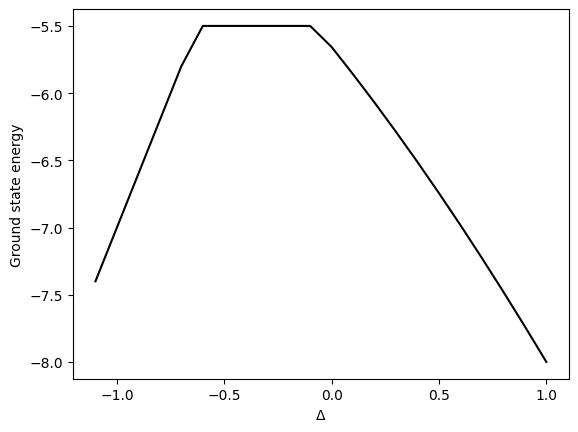

In [5]:
def spin_ham_XXZ(n, lam, delta):
    coeff = []
    operators = []

    # periodic boundary conditions (just so that it wraps around)
    operators.append(qml.PauliX(n-1) @ qml.PauliX(0))
    coeff.append(1.0)
    operators.append(qml.PauliY(n-1) @ qml.PauliY(0))
    coeff.append(1.0)
    operators.append(qml.PauliZ(n-1) @ qml.PauliZ(0))
    coeff.append(delta)

    for i in range(n-1):
        # XX coupling
        operators.append(qml.PauliX(i) @ qml.PauliX(i+1))
        coeff.append(1.0)

        # YY coupling
        operators.append(qml.PauliY(i) @ qml.PauliY(i+1))
        coeff.append(1.0)
        
        # ZZ coupling
        operators.append(qml.PauliZ(i) @ qml.PauliZ(i+1))
        coeff.append(delta)

    #transverse field
    for i in range(n):
        operators.append(qml.PauliZ(i))
        coeff.append(lam)
    return qml.Hamiltonian(coeff, operators)

# Function to compute the ground state energy
def ground_state(n, lam, delta):
    H = spin_ham_XXZ(n, lam, delta)
    H_matrix = qml.matrix(H, wire_order=list(range(n)))
    eigvals = np.linalg.eigvals(H_matrix)
    return min(eigvals)


exac = []
delta = np.arange(-1.1, 1.1, 0.1)
lam = 0.75
for d in delta:
    E0 = ground_state(n=num_qubits, delta=d, lam=lam)
    exac.append(E0)
plt.plot(delta, exac, label='Exact', color='black')
plt.xlabel('Δ')
plt.ylabel('Ground state energy')


In [6]:
# function to generate single qubit rotation gates
def single_rot(phi,theta, target):
    qml.RZ(phi, wires=target) 
    qml.RY(theta, wires=target)

In [7]:
# Function to generate encoding and processing layers
def processing_layer(proc_params, target, n, num_layers):
    for i in range(num_layers):
        p = i % 2  #even/odd check
        for j in range(n):
            phi, theta = proc_params[i][j]
            single_rot(phi, theta, target[j])
        for j in range(p, n-1, 2):
            qml.CNOT(wires=[target[j], target[j+1]])

def encoding_layer(enc_params, w_params, delta, target, n, num_layers):
    for i in range(num_layers):
        p = i % 2
        for j in range(n):
            phi, theta = enc_params[i][j]
            wth, wph = w_params[i][j]
            single_rot(wth * delta + phi, wph * delta + theta, target[j])
        for j in range(p, n - 1, 2):
            qml.CNOT(wires=[target[j], target[j + 1]])


<class 'numpy.ndarray'>
(<Figure size 1500x500 with 1 Axes>, <Axes: >)


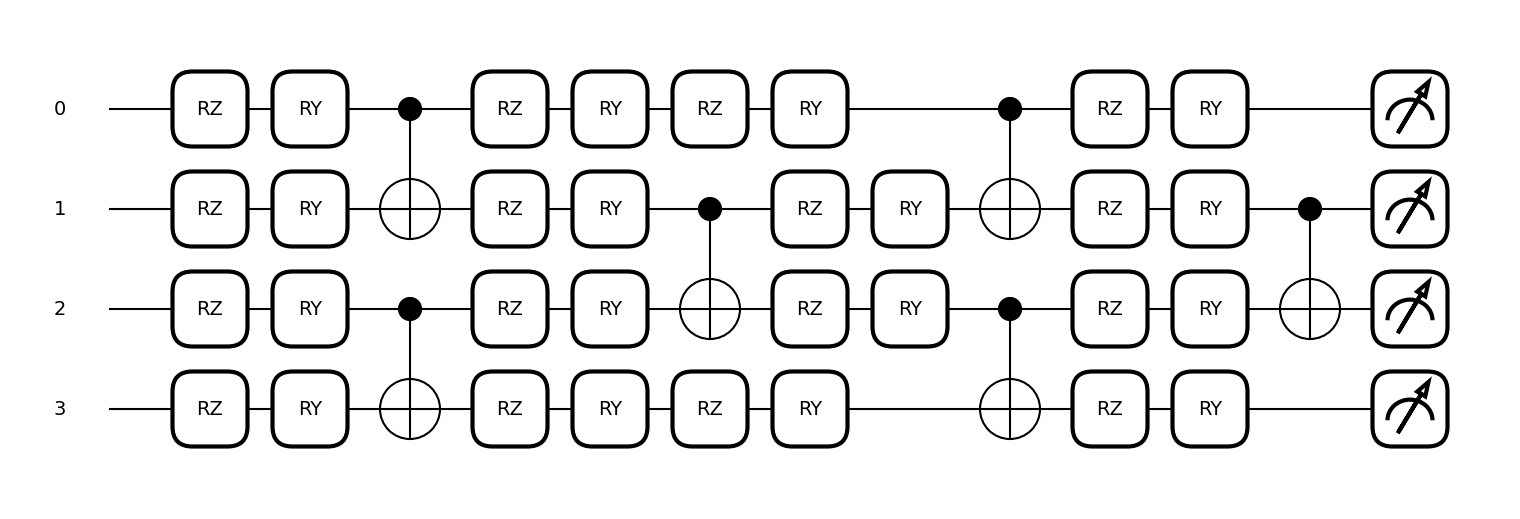

In [8]:
# Function to check if the ansatz circuit matches the one in the paper
@qml.qnode(dev)
def circuit(proc_params, enc_params, w_params, n, lam, delta, num_layers):
    ham = spin_ham_XXZ(n, lam, delta)
    # encoding layer
    encoding_layer(enc_params, w_params, delta, range(n), n, num_layers)
    # processing layer
    processing_layer(proc_params, range(n), n, num_layers)

    return qml.expval(ham)


num_layers = 2

w_params = np.random.uniform(0, np.pi, (num_layers, num_qubits, 2)) 
proc_params = np.random.uniform(0, np.pi, (num_layers, num_qubits, 2))
enc_params = np.random.uniform(0, np.pi, (num_layers, num_qubits, 2))


print(type(proc_params))
drawer = qml.draw_mpl(circuit)
print(drawer(proc_params, enc_params, w_params, num_qubits, lam, 0.8, num_layers)) 


<class 'numpy.ndarray'>
0.3943783137166745


Text(0.5, 1.0, 'Expectation value of Hamiltonian vs Delta')

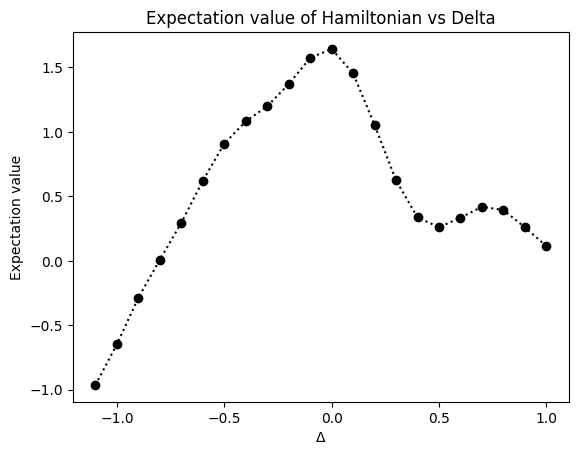

In [9]:
@qml.qnode(dev)
def expectation_value(proc_params,enc_params, w_params, n, lam, delta):
    
    ham = spin_ham_XXZ(n, lam, delta)
    # encoding layer
    encoding_layer(enc_params,w_params, delta, range(n), n, 2)
    # processing layer
    processing_layer(proc_params, range(n), n, 1)
    return qml.expval(ham)

# little check on the type of the output
exp_value = expectation_value(proc_params, enc_params, w_params, n=num_qubits, lam=lam, delta=0.8)
print(type(exp_value))
print(exp_value)

# compute the expectation value for different delta values in the range [-1.1, 1.1] defined above
exp_vals = []
for d in delta:
    exp_val = expectation_value(proc_params, enc_params, w_params, n=num_qubits, lam=lam, delta=d)
    exp_vals.append(exp_val)

   

plt.plot(delta, exp_vals, marker='o', linestyle=':', color='black')
plt.xlabel('Δ')
plt.ylabel('Expectation value')
plt.title('Expectation value of Hamiltonian vs Delta')

### Meta-VQE with Adam optimizer

In [10]:
# generate circuit
@qml.qnode(dev, diff_method="best")
def meta_vqe_circuit(proc_params, enc_params, w_params, n, lam, delta, num_layers):
    # encoding layer
    encoding_layer(enc_params,w_params, delta, range(n), n, num_layers)
    # processing layer
    processing_layer(proc_params, range(n), n, 1)

    ham = spin_ham_XXZ(n, lam, delta)
    return qml.expval(ham)


def loss_function(proc_params, enc_params, w_params, n, lam, deltas):
    loss = 0
    for delta in deltas:
        loss += meta_vqe_circuit(proc_params, enc_params, w_params, n, lam, delta, num_layers)
    return loss/len(deltas)

In [11]:
# Generating the training set 
n_train = 20
n_test = 100

delta_min = 1.1
delta_max = -1.1
deltas_train = [delta_min + (delta_max - delta_min) * i / (n_train - 1) for i in range(n_train)]
lam = 0.75

#number of layers for each type of layer
enc_n_layers = 2
proc_n_layers = 1

init_proc_params = np.random.uniform(0, np.pi, (proc_n_layers, num_qubits, 2))
init_enc_params = np.random.uniform(0, np.pi, (enc_n_layers, num_qubits, 2))
init_w_params = np.random.uniform(0, np.pi, (enc_n_layers, num_qubits, 2))


In [12]:
opt = qml.AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.999)
losses = []

current_proc_params = qml.numpy.array(init_proc_params, requires_grad=True)
current_enc_params = qml.numpy.array(init_enc_params, requires_grad=True)
current_w_params = qml.numpy.array(init_w_params, requires_grad=True)

# Track best parameters based on loss
best_loss = float('inf')
best_proc_params = None
best_enc_params = None
best_w_params = None

for i in range(n_train):
    
    (current_proc_params, current_enc_params, current_w_params), curr_loss = opt.step_and_cost(
        lambda pp, ep, wp: loss_function(pp, ep, wp, num_qubits, lam, deltas_train), current_proc_params,
        current_enc_params, current_w_params)
    losses.append(curr_loss)
    
    # Store best parameters
    if curr_loss < best_loss:
        best_loss = curr_loss
        best_proc_params = current_proc_params.copy()
        best_enc_params = current_enc_params.copy()
        best_w_params = current_w_params.copy()
    
    print(f"Step {i}: Loss = {curr_loss:.6f}")
    # print('best encoding params:', best_enc_params)
    # print('best weight params:', best_w_params)

# Store final trained parameters (using best found parameters)
trained_proc_params = best_proc_params
trained_enc_params = best_enc_params
trained_w_params = best_w_params

Step 0: Loss = 0.060507
Step 1: Loss = -0.651712
Step 2: Loss = -1.308981
Step 3: Loss = -1.866325
Step 4: Loss = -2.297636
Step 5: Loss = -2.595761
Step 6: Loss = -2.797825
Step 7: Loss = -2.949187
Step 8: Loss = -3.064130
Step 9: Loss = -3.161471
Step 10: Loss = -3.267047
Step 11: Loss = -3.377796
Step 12: Loss = -3.477751
Step 13: Loss = -3.562169
Step 14: Loss = -3.638232
Step 15: Loss = -3.713088
Step 16: Loss = -3.788631
Step 17: Loss = -3.862629
Step 18: Loss = -3.930061
Step 19: Loss = -3.984287


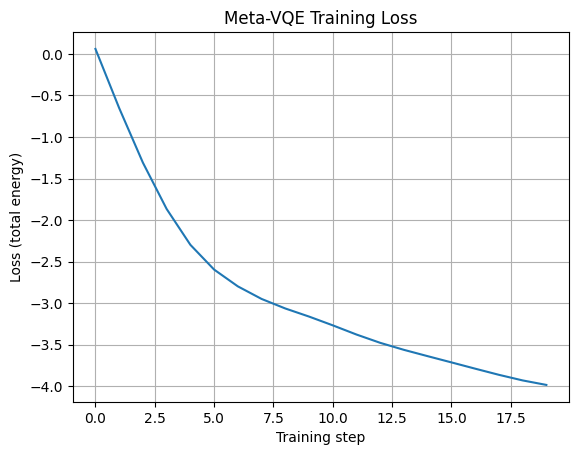

In [13]:
plt.plot(losses)
plt.xlabel("Training step")
plt.ylabel("Loss (total energy)")
plt.title("Meta-VQE Training Loss")
plt.grid()
plt.show()

In [14]:
x_train = deltas_train 
y_train_ex = []
y_train_metaVQE = []
error_train_metaVQE = []

# Loop over all training points
for delta in deltas_train:
    # Use trained parameters to evaluate the circuit
    pred_energy = meta_vqe_circuit(trained_proc_params, trained_enc_params, 
                                   trained_w_params, num_qubits, lam, delta, num_layers)

    # Reference exact solution 
    true_energy = ground_state(num_qubits, lam, delta)

    print(delta, true_energy, pred_energy, abs(pred_energy-true_energy))
    # Store results
    y_train_metaVQE.append(pred_energy)
    y_train_ex.append(true_energy)
    error_train_metaVQE.append(abs(pred_energy - true_energy))


1.1 (-8.269596362197392+0j) -4.9259518413002645 3.3436445208971275
0.9842105263157895 (-7.957968735090017+0j) -5.558081933489386 2.3998868016006307
0.868421052631579 (-7.654326410152783-2.5788741912857425e-32j) -5.516276882005934 2.1380495281468495
0.7526315789473685 (-7.358964309688821-5.258244272280804e-32j) -5.188524056651827 2.1704402530369933
0.6368421052631579 (-7.0721556874022795+1.1967515713430746e-32j) -4.878440712361526 2.193714975040754
0.5210526315789474 (-6.794146933686838-1.906013951685095e-51j) -4.633505313250431 2.1606416204364063
0.4052631578947369 (-6.525152542288214+0j) -4.386343463883448 2.1388090784047655
0.2894736842105263 (-6.265350454327089+0j) -4.098634412753414 2.1667160415736744
0.17368421052631577 (-6.014877999336955+0j) -3.7544505254712597 2.260427473865695
0.05789473684210522 (-5.773828639527448+0j) -3.329279961787013 2.444548677740435
-0.05789473684210522 (-5.542249692159046+0j) -2.885145954046346 2.6571037381126996
-0.17368421052631589 (-5.50000000000000

In [15]:
deltas_test = [np.random.uniform(delta_min, delta_max) for _ in range(n_test)]
deltas_test.sort()

x_test = deltas_test
y_test_ex = []
y_test_metaVQE = []
error_test_metaVQE = []

# Inference on test points
for delta in x_test:
    pred_energy = meta_vqe_circuit(trained_proc_params, trained_enc_params, 
                                   trained_w_params, num_qubits, lam, delta, num_layers)
    exact_energy = ground_state(num_qubits, lam, delta) 

    y_test_metaVQE.append(pred_energy)
    y_test_ex.append(exact_energy)
    error_test_metaVQE.append(abs(pred_energy - exact_energy))


/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


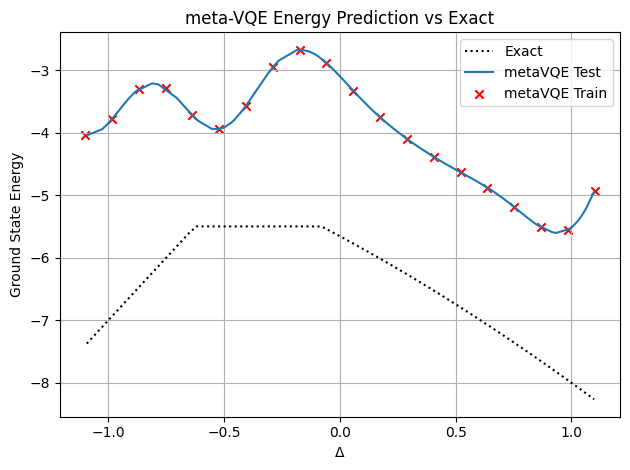

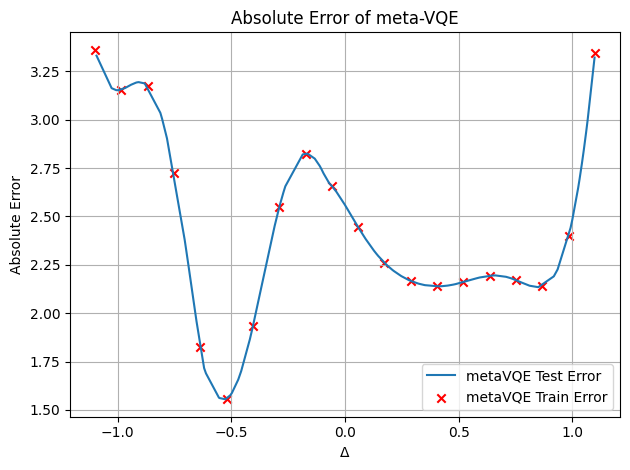

In [16]:
# Ground state energy plot
plt.plot(x_test, y_test_ex, color="black", linestyle=":", label="Exact")
plt.plot(x_test, y_test_metaVQE, linestyle="-", label="metaVQE Test")
plt.scatter(x_train, y_train_metaVQE, color="red", marker="x", label="metaVQE Train")
plt.xlabel(r"$\Delta$")
plt.ylabel("Ground State Energy")
plt.title("meta-VQE Energy Prediction vs Exact")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Absolute error plot
plt.plot(x_test, error_test_metaVQE, linestyle="-", label="metaVQE Test Error")
plt.scatter(x_train, error_train_metaVQE, color="red", marker="x", label="metaVQE Train Error")
plt.xlabel(r"$\Delta$")
plt.ylabel("Absolute Error")
plt.title("Absolute Error of meta-VQE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Standard VQE

In [ ]:
# the main difference between VQE and meta-VQE is that all layers are equivalent to processing layers
@qml.qnode(dev, diff_method="best")
def vqe_circuit(proc_params, n, lam, delta):
    processing_layer(proc_params, range(n), n, enc_n_layers+proc_n_layers)
    ham = spin_ham_XXZ(n, lam, delta)
    return qml.expval(ham)

In [ ]:

losses = []
y_VQE = []
error_yVQE = []

# Define the cost function for each delta value
def cost_fn(params,delta):
    return vqe_circuit(params, num_qubits, lam, delta)

for i in range(n_train):
    delta = deltas_train[i]

    vqe_proc_params = np.random.uniform(0, np.pi, (proc_n_layers+enc_n_layers, num_qubits, 2))
    vqe_proc_params_qml = qml.numpy.array(vqe_proc_params, requires_grad=True) 

    vqe_loss = opt.step_and_cost(
        lambda pp: cost_fn(pp, delta), vqe_proc_params_qml)

    losses.append(vqe_loss) 
    
    
    # Store results
    
    y_VQE.append(vqe_loss)
    error_yVQE.append(abs(vqe_loss - y_train_ex[i]))
    
    print(deltas_train[i], y_train_ex[i], vqe_loss, abs(vqe_loss - y_train_ex[i]))

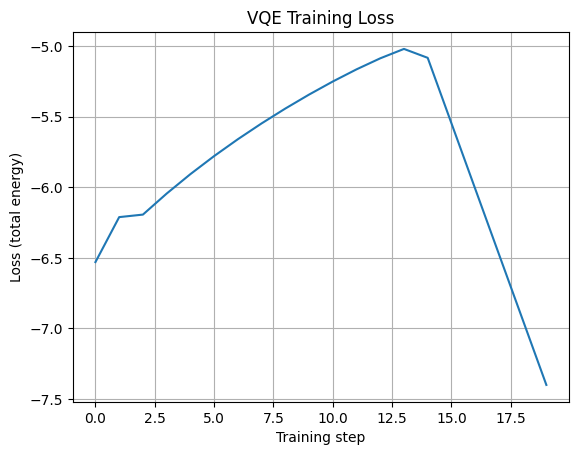

In [35]:
plt.plot(losses)
plt.xlabel("Training step")
plt.ylabel("Loss (total energy)")
plt.title("VQE Training Loss")
plt.grid()
plt.show()

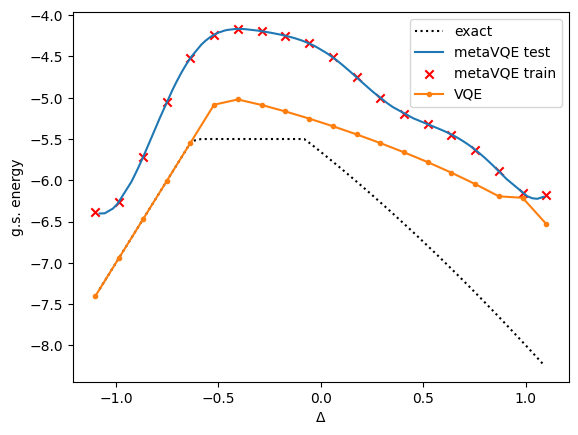

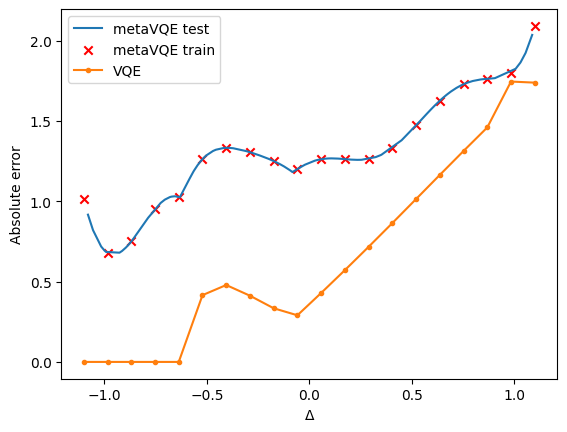

In [36]:
plt.plot(x_test, y_test_ex, color="black", ls=":", label="exact")
plt.plot(x_test, y_test_metaVQE,  ls="-", label="metaVQE test")
plt.scatter(x_train, y_train_metaVQE, color="red", marker="x", label="metaVQE train")
plt.plot(x_train, y_VQE,  marker=".", label="VQE")
plt.xlabel("Δ")
plt.ylabel('g.s. energy')
plt.legend()
plt.show()


plt.plot(x_test, error_test_metaVQE, ls="-", label="metaVQE test")
plt.scatter(x_train, error_train_metaVQE, marker="x", color="red", label="metaVQE train")
plt.plot(x_train, error_yVQE, marker=".", label="VQE")
plt.xlabel("Δ")
plt.ylabel("Absolute error")
plt.legend()
plt.show()



### OPT-meta-VQE

In [37]:
@qml.qnode(dev, diff_method="best")
def opt_meta_vqe_circuit(proc_params, enc_params, w_params, n, lam, delta, num_layers):
    # encoding layer
    encoding_layer(enc_params,w_params, delta, range(n), n, num_layers)
    # processing layer
    processing_layer(proc_params, range(n), n, 1)

    ham = spin_ham_XXZ(n, lam, delta)
    return qml.expval(ham)

In [38]:
# Initialize the parameters
opt_proc_params = trained_proc_params.copy()
opt_enc_params = trained_enc_params.copy()
opt_w_params = trained_w_params.copy()

In [ ]:

y_opt_metaVQE = []
error_y_opt_metaVQE = []

# Define the cost function
def opt_cost_fn(proc_params, enc_params, w_params, delta):
    # Reshape flat_params back to original shapes
    
    return opt_meta_vqe_circuit(proc_params, enc_params, 
                                w_params, num_qubits, lam, delta, num_layers)

for i in range(n_train):
    delta = deltas_train[i]
    
    opt_vqe_loss = opt.step_and_cost(
        lambda pp, ep, wp: cost_fn(pp, ep, wp, delta), vqe_proc_params_qml)
    
    # Store results
    y_opt_metaVQE.append(opt_vqe_loss)
    error_y_opt_metaVQE.append(abs(opt_vqe_loss - y_train_ex[i]))
    
    print(deltas_train[i], y_train_ex[i], opt_vqe_loss, abs(opt_vqe_loss - y_train_ex[i]))


1.1 (-8.269596362197392+0j) -6.530349103365857 1.7392472588315346
0.9842105263157895 (-7.957968735090017+0j) -6.354521895035079 1.6034468400549375
0.868421052631579 (-7.654326410152783-2.5788741912857425e-32j) -6.1940943949179275 1.4602320152348556
0.7526315789473685 (-7.358964309688821-5.258244272280804e-32j) -6.0453734315049985 1.3135908781838221
0.6368421052631579 (-7.0721556874022795+1.1967515713430746e-32j) -5.907678515391152 1.1644771720111278
0.5210526315789474 (-6.794146933686838-1.906013951685095e-51j) -5.779850492005888 1.0142964416809495
0.4052631578947369 (-6.525152542288214+0j) -5.660504160775979 0.864648381512235
0.2894736842105263 (-6.265350454327089+0j) -5.548574373478202 0.716776080848887
0.17368421052631577 (-6.014877999336955+0j) -5.443371645148618 0.5715063541883367
0.05789473684210522 (-5.773828639527448+0j) -5.344500031124326 0.4293286084031216
-0.05789473684210522 (-5.542249692159046+0j) -5.251868133509976 0.2903815586490692
-0.17368421052631589 (-5.5000000000000

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


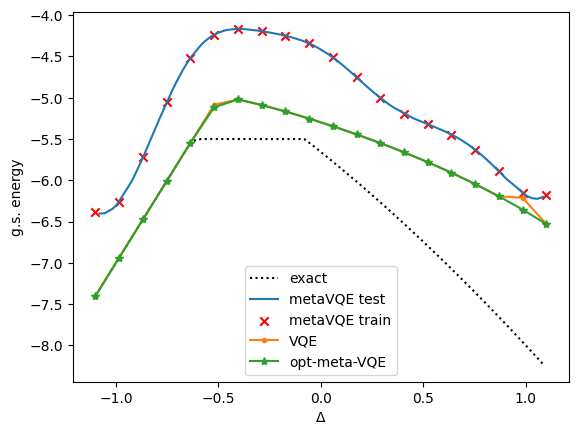

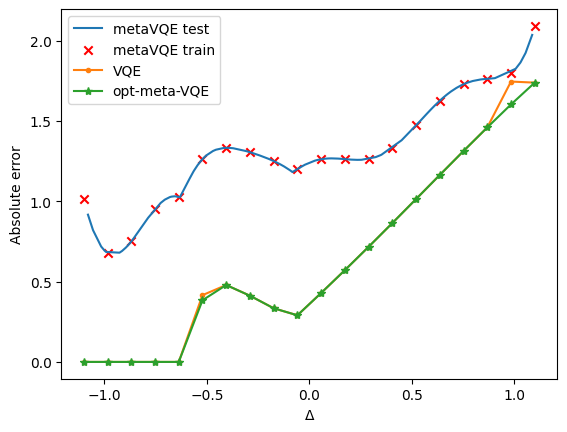

In [41]:
plt.plot(x_test, y_test_ex, color="black", ls=":", label="exact")
plt.plot(x_test, y_test_metaVQE,  ls="-", label="metaVQE test")
plt.scatter(x_train, y_train_metaVQE, color="red", marker="x", label="metaVQE train")
plt.plot(x_train, y_VQE,  marker=".", label="VQE")
plt.plot(x_train, y_opt_metaVQE, marker="*", label="opt-meta-VQE")


plt.xlabel("Δ")
plt.ylabel('g.s. energy')
plt.legend()

plt.show()

# Absolute error

plt.plot(x_test, error_test_metaVQE, ls="-", label="metaVQE test")
plt.scatter(x_train, error_train_metaVQE, marker="x", color="red", label="metaVQE train")
plt.plot(x_train, error_yVQE, marker=".", label="VQE")
plt.plot(x_train, error_y_opt_metaVQE, marker="*", label="opt-meta-VQE")


plt.xlabel("Δ")
plt.ylabel("Absolute error")
plt.legend()
plt.show()

